In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import genextreme as gev

from unseen import fileio
from unseen import stability
from unseen import indices

In [2]:
agcd_file = "/g/data/xv83/dbi599/east-coast-rain/data/Rx15day_AGCD-CSIRO_r005_1900-2022_annual-aug-to-sep_east-coast-flood-region.zarr.zip"

In [3]:
agcd_ds = fileio.open_dataset(agcd_file)
agcd_ds = agcd_ds.dropna('time')

In [4]:
agcd_max = agcd_ds['pr'].values.max()
print(agcd_max)

410.43057


In [5]:
# Obs GEV (with record event)
gev_xvals = np.arange(0, 500)

agcd_gev_shape, agcd_gev_loc, agcd_gev_scale = indices.fit_gev(agcd_ds['pr'].values)
agcd_gev_pdf = gev.pdf(gev_xvals, agcd_gev_shape, agcd_gev_loc, agcd_gev_scale)
agcd_return_periods_gev, agcd_return_values_gev = stability.return_curve(
    agcd_ds['pr'],
    'gev',
    params=[agcd_gev_shape, agcd_gev_loc, agcd_gev_scale]
)
agcd_return_periods_empirical, agcd_return_values_empirical = stability.return_curve(
    agcd_ds['pr'],
    'empirical',
    params=[agcd_gev_shape, agcd_gev_loc, agcd_gev_scale]
)

In [6]:
# Obs GEV (without record event)
agcdn_gev_shape, agcdn_gev_loc, agcdn_gev_scale = indices.fit_gev(agcd_ds['pr'].values[:-1])
agcdn_gev_pdf = gev.pdf(gev_xvals, agcdn_gev_shape, agcdn_gev_loc, agcdn_gev_scale)
agcdn_return_periods_gev, agcdn_return_values_gev = stability.return_curve(
    agcd_ds['pr'][:-1],
    'gev',
    params=[agcdn_gev_shape, agcdn_gev_loc, agcdn_gev_scale]
)

In [7]:
model_raw_files = {
    'CAFE': "/g/data/xv83/dbi599/east-coast-rain/data/Rx15day_CAFE-c5-d60-pX-f6_19950501-20201101_annual-aug-to-sep_east-coast-flood-region.zarr.zip",
    'CanESM5': "/g/data/xv83/dbi599/east-coast-rain/data/Rx15day_CanESM5-dcppA-hindcast_196101-201701_annual-aug-to-sep_east-coast-flood-region.zarr.zip",
    'CMCC-CM2-SR5': "/g/data/xv83/dbi599/east-coast-rain/data/Rx15day_CMCC-CM2-SR5-dcppA-hindcast_196011-201911_annual-aug-to-sep_east-coast-flood-region.zarr.zip",
    'EC-Earth3': "/g/data/xv83/dbi599/east-coast-rain/data/Rx15day_EC-Earth3-dcppA-hindcast_196011-201711_annual-aug-to-sep_east-coast-flood-region.zarr.zip",
    'HadGEM3-GC31-MM': "/g/data/xv83/dbi599/east-coast-rain/data/Rx15day_HadGEM3-GC31-MM-dcppA-hindcast_196011-201811_annual-aug-to-sep_east-coast-flood-region.zarr.zip",
    'IPSL-CM6A-LR': "/g/data/xv83/dbi599/east-coast-rain/data/Rx15day_IPSL-CM6A-LR-dcppA-hindcast_196101-201701_annual-aug-to-sep_east-coast-flood-region.zarr.zip",
    'MIROC6': "/g/data/xv83/dbi599/east-coast-rain/data/Rx15day_MIROC6-dcppA-hindcast_196011-201811_annual-aug-to-sep_east-coast-flood-region.zarr.zip",
    'MPI-ESM1-2-HR': "/g/data/xv83/dbi599/east-coast-rain/data/Rx15day_MPI-ESM1-2-HR-dcppA-hindcast_196011-201811_annual-aug-to-sep_east-coast-flood-region.zarr.zip",
    'MRI-ESM2-0': "/g/data/xv83/dbi599/east-coast-rain/data/Rx15day_MRI-ESM2-0-dcppA-hindcast_196011-201911_annual-aug-to-sep_east-coast-flood-region.zarr.zip",
    'NorCPM1': "/g/data/xv83/dbi599/east-coast-rain/data/Rx15day_NorCPM1-dcppA-hindcast_196010-201810_annual-aug-to-sep_east-coast-flood-region.zarr.zip",
}

In [8]:
model_mulc_files = {
    'CAFE': "/g/data/xv83/dbi599/east-coast-rain/data/Rx15day_CAFE-c5-d60-pX-f6_19950501-20201101_annual-aug-to-sep_east-coast-flood-region_bias-corrected-AGCD-CSIRO-multiplicative.zarr.zip",
    'CanESM5': "/g/data/xv83/dbi599/east-coast-rain/data/Rx15day_CanESM5-dcppA-hindcast_196101-201701_annual-aug-to-sep_east-coast-flood-region_bias-corrected-AGCD-CSIRO-multiplicative.zarr.zip",
    'CMCC-CM2-SR5': "/g/data/xv83/dbi599/east-coast-rain/data/Rx15day_CMCC-CM2-SR5-dcppA-hindcast_196011-201911_annual-aug-to-sep_east-coast-flood-region_bias-corrected-AGCD-CSIRO-multiplicative.zarr.zip",
    'EC-Earth3': "/g/data/xv83/dbi599/east-coast-rain/data/Rx15day_EC-Earth3-dcppA-hindcast_196011-201711_annual-aug-to-sep_east-coast-flood-region_bias-corrected-AGCD-CSIRO-multiplicative.zarr.zip",
    'HadGEM3-GC31-MM': "/g/data/xv83/dbi599/east-coast-rain/data/Rx15day_HadGEM3-GC31-MM-dcppA-hindcast_196011-201811_annual-aug-to-sep_east-coast-flood-region_bias-corrected-AGCD-CSIRO-multiplicative.zarr.zip",
    'IPSL-CM6A-LR': "/g/data/xv83/dbi599/east-coast-rain/data/Rx15day_IPSL-CM6A-LR-dcppA-hindcast_196101-201701_annual-aug-to-sep_east-coast-flood-region_bias-corrected-AGCD-CSIRO-multiplicative.zarr.zip",
    'MIROC6': "/g/data/xv83/dbi599/east-coast-rain/data/Rx15day_MIROC6-dcppA-hindcast_196011-201811_annual-aug-to-sep_east-coast-flood-region_bias-corrected-AGCD-CSIRO-multiplicative.zarr.zip",
    'MPI-ESM1-2-HR': "/g/data/xv83/dbi599/east-coast-rain/data/Rx15day_MPI-ESM1-2-HR-dcppA-hindcast_196011-201811_annual-aug-to-sep_east-coast-flood-region_bias-corrected-AGCD-CSIRO-multiplicative.zarr.zip",
    'MRI-ESM2-0': "/g/data/xv83/dbi599/east-coast-rain/data/Rx15day_MRI-ESM2-0-dcppA-hindcast_196011-201911_annual-aug-to-sep_east-coast-flood-region_bias-corrected-AGCD-CSIRO-multiplicative.zarr.zip",
    'NorCPM1': "/g/data/xv83/dbi599/east-coast-rain/data/Rx15day_NorCPM1-dcppA-hindcast_196010-201810_annual-aug-to-sep_east-coast-flood-region_bias-corrected-AGCD-CSIRO-multiplicative.zarr.zip",
}
# NorCPM1 fails the similarity test

In [92]:
model_mulc_data = {}
model_mulc_pdfs = {}
model_mulc_returns_gev = {}
model_mulc_event_returns_gev = {}
model_mulc_returns_empirical = {}
model_raw_data = {}
model_raw_pdfs = {}

for model_name in model_mulc_files:
    #Data
    model_mulc_file = model_mulc_files[model_name]
    model_mulc_ds = fileio.open_dataset(model_mulc_file)
    model_mulc_da = model_mulc_ds['pr'].dropna('lead_time').stack({'sample': ['ensemble', 'init_date', 'lead_time']})

    model_raw_file = model_raw_files[model_name]
    model_raw_ds = fileio.open_dataset(model_raw_file)
    model_raw_da = model_raw_ds['pr'].dropna('lead_time').stack({'sample': ['ensemble', 'init_date', 'lead_time']})

    #PDFs
    model_mulc_gev_shape, model_mulc_gev_loc, model_mulc_gev_scale = indices.fit_gev(model_mulc_da.values)
    model_mulc_gev_pdf = gev.pdf(gev_xvals, model_mulc_gev_shape, model_mulc_gev_loc, model_mulc_gev_scale)
    model_mulc_gev_event_probability = gev.sf(
        agcd_max,
        model_mulc_gev_shape,
        loc=model_mulc_gev_loc,
        scale=model_mulc_gev_scale,
    )
    model_mulc_gev_event_return_period = 1. / model_mulc_gev_event_probability
    
    model_raw_gev_shape, model_raw_gev_loc, model_raw_gev_scale = indices.fit_gev(model_raw_da.values)
    model_raw_gev_pdf = gev.pdf(gev_xvals, model_raw_gev_shape, model_raw_gev_loc, model_raw_gev_scale)
    
    #Return periods
    model_mulc_return_periods_gev, model_mulc_return_values_gev = stability.return_curve(
        model_mulc_da,
        'gev',
        params=[model_mulc_gev_shape, model_mulc_gev_loc, model_mulc_gev_scale],
    )
    model_mulc_return_periods_empirical, model_mulc_return_values_empirical = stability.return_curve(
        model_mulc_da,
        'empirical',
        params=[model_mulc_gev_shape, model_mulc_gev_loc, model_mulc_gev_scale],
    )
    
    model_mulc_data[model_name] = model_mulc_da
    model_mulc_pdfs[model_name] = model_mulc_gev_pdf
    model_mulc_returns_gev[model_name] = (model_mulc_return_periods_gev, model_mulc_return_values_gev)
    model_mulc_event_returns_gev[model_name] = model_mulc_gev_event_return_period
    model_mulc_returns_empirical[model_name] = (model_mulc_return_periods_empirical, model_mulc_return_values_empirical)
    model_raw_data[model_name] = model_raw_da
    model_raw_pdfs[model_name] = model_raw_gev_pdf

/g/data/xv83/dbi599/east-coast-rain/figures/Rx15day_gev-pdf-and-return-curves_ensemble.png


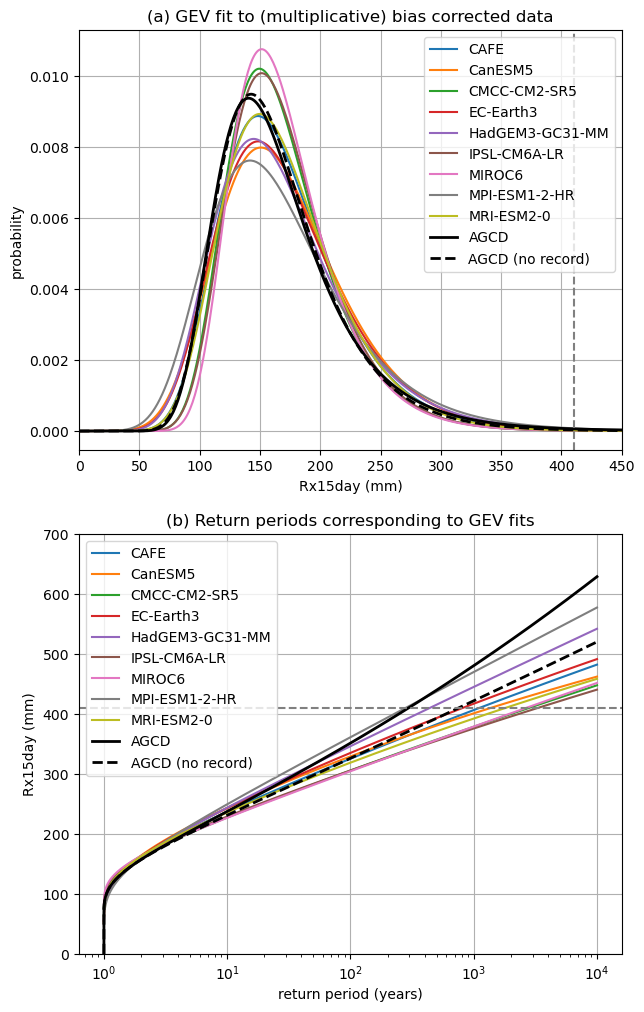

In [10]:
fig = plt.figure(figsize=[7, 12])
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

plot_models = [
    'CAFE', 
    'CanESM5',
    'CMCC-CM2-SR5',
    'EC-Earth3',
    'HadGEM3-GC31-MM',
    'IPSL-CM6A-LR',
    'MIROC6',
    'MPI-ESM1-2-HR',
    'MRI-ESM2-0',
]
for model_name in plot_models:
    model_gev_pdf = model_mulc_pdfs[model_name]
    ax1.plot(gev_xvals, model_gev_pdf, label=model_name)
        
    model_return_periods, model_return_values = model_mulc_returns_gev[model_name]
    ax2.plot(model_return_periods, model_return_values, label=model_name)

# Plot obs GEV (with record event)
ax1.plot(gev_xvals, agcd_gev_pdf, color='black', linewidth=2.0, label='AGCD')
ax2.plot(agcd_return_periods_gev, agcd_return_values_gev, label='AGCD', color='black', linewidth=2.0)

# Plot obs GEV (without record event)
ax1.plot(gev_xvals, agcdn_gev_pdf, color='black', linewidth=2.0, label='AGCD (no record)', linestyle='--')
ax2.plot(agcdn_return_periods_gev, agcdn_return_values_gev, label='AGCD (no record)', color='black', linewidth=2.0, linestyle='--')
    
ax1.grid()
ax1.set_xlabel('Rx15day (mm)')
ax1.set_ylabel('probability')
ax1.axvline(agcd_max, color='0.5', linestyle='--')
ax1.set_title('(a) GEV fit to (multiplicative) bias corrected data')
ax1.set_xlim([0, 450])
ax1.legend()

ax2.legend()
ax2.axhline(agcd_max, color='0.5', linestyle='--')
ax2.set_xscale('log')
ax2.set_xlabel('return period (years)')
ax2.set_ylabel('Rx15day (mm)')
ax2.set_title('(b) Return periods corresponding to GEV fits')
ax2.set_ylim([0, 700])
ax2.grid()

outfile = '/g/data/xv83/dbi599/east-coast-rain/figures/Rx15day_gev-pdf-and-return-curves_ensemble.png'
plt.savefig(outfile, bbox_inches='tight', facecolor='white', dpi=400)
print(outfile)
plt.show()

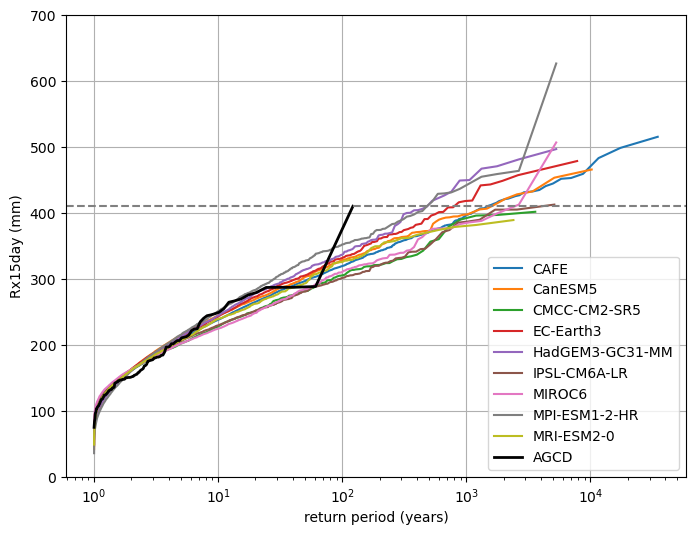

In [11]:
fig = plt.figure(figsize=[8, 6])
ax = fig.add_subplot()

# Plot models
for model_name in plot_models:
    model_return_periods, model_return_values = model_mulc_returns_empirical[model_name]
    ax.plot(model_return_periods, model_return_values, label=model_name)

# Plot obs
ax.plot(agcd_return_periods_empirical, agcd_return_values_empirical, label='AGCD', color='black', linewidth=2.0)
    
ax.legend()
ax.axhline(agcd_max, color='0.5', linestyle='--')
ax.set_xscale('log')
ax.set_xlabel('return period (years)')
ax.set_ylabel('Rx15day (mm)')
ax.set_ylim([0, 700])
ax.grid()

#plt.savefig(outfile, bbox_inches='tight', facecolor='white', dpi=dpi)
#print(outfile)
plt.show()

In [104]:
def plot_distributions(ax, model_name, letter, include_additive=False, xlabel=None, ylabel=None):
    """Plot various distributions"""
    
    model_raw_da = model_raw_data[model_name]
    model_raw_da.plot.hist(ax=ax, bins=50, density=True, alpha=0.7, facecolor='tab:blue')
    model_raw_gev_pdf = model_raw_pdfs[model_name]
    ax.plot(gev_xvals, model_raw_gev_pdf, color='tab:blue', linewidth=4.0, label='model')

    model_mulc_da = model_mulc_data[model_name]
    model_mulc_da.plot.hist(ax=ax, bins=50, density=True, facecolor='tab:orange', alpha=0.7)
    model_mulc_gev_pdf = model_mulc_pdfs[model_name]
    ax.plot(gev_xvals, model_mulc_gev_pdf, color='tab:orange', linewidth=4.0, label='model (corrected)')

    agcd_ds['pr'].plot.hist(ax=ax, bins=50, density=True, facecolor='tab:gray', alpha=0.7)
    ax.plot(gev_xvals, agcd_gev_pdf, color='tab:gray', linewidth=4.0, label='observations')

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(f'({letter}) {model_name}')
    ax.set_xlim(0, 450)
    ax.grid()
    if letter == 'a':
        ax.legend()
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax.yaxis.major.formatter._useMathText = True
    
    event_return = model_mulc_event_returns_gev[model_name]
    ax.text(0.98, 0.15, f'{event_return:.0f} years', transform=ax.transAxes, color='tab:orange', horizontalalignment='right')

/g/data/xv83/dbi599/east-coast-rain/figures/Rx15day_ensemble_pdfs.png


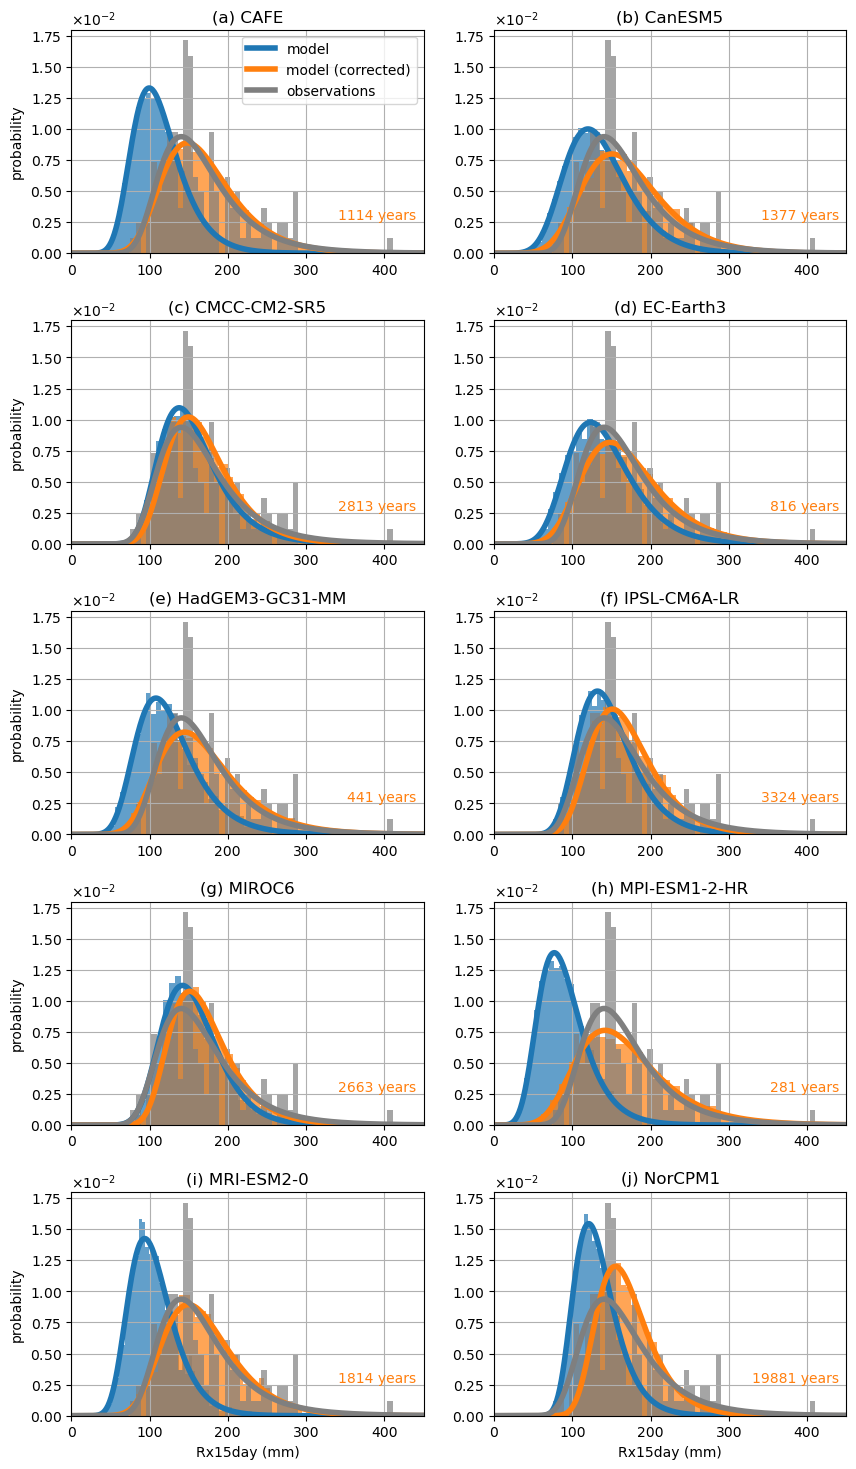

In [105]:
fig, axes = plt.subplots(5, 2, figsize=[10, 18])
fig_letters = 'abcdefghij'
models = [
    'CAFE', 
    'CanESM5',
    'CMCC-CM2-SR5',
    'EC-Earth3',
    'HadGEM3-GC31-MM',
    'IPSL-CM6A-LR',
    'MIROC6',
    'MPI-ESM1-2-HR',
    'MRI-ESM2-0',
    'NorCPM1'
]
plot_coords = [
    (0, 0),
    (0, 1),
    (1, 0),
    (1, 1),
    (2, 0),
    (2, 1),
    (3, 0),
    (3, 1),
    (4, 0),
    (4, 1),
]

for plot_num, model_name in enumerate(models):
    fig_letter = fig_letters[plot_num]
    row, col = plot_coords[plot_num]
    ax = axes[row][col]
    ylabel = 'probability' if col == 0 else None
    xlabel = 'Rx15day (mm)' if row == 4 else None
    plot_distributions(ax, model_name, fig_letter, include_additive=False, ylabel=ylabel, xlabel=xlabel)

plt.subplots_adjust(hspace=0.3)
outfile = '/g/data/xv83/dbi599/east-coast-rain/figures/Rx15day_ensemble_pdfs.png'
plt.savefig(outfile, bbox_inches='tight', facecolor='white', dpi=400)
print(outfile)
plt.show()